# Web Services

In [1]:
from pygeoogc import ArcGISRESTful, WFS, WMS, ServiceURL
import pygeoutils as geoutils
from pynhd import NLDI
import numpy as np

[PyGeoOGC](https://github.com/cheginit/pygeoogc) and [PyGeoUtils](https://github.com/cheginit/pygeoutils) can be used to access any web services that are based on ArcGIS RESTful, WMS, or WFS. It is noted that although, all these web service have limits on the number of objects (e.g., 1000 objectIDs for RESTful) or pixels (e.g., 8 million pixels) per requests, PyGeoOGC takes care of dividing the requests into smaller chunks under-the-hood and then merges them.

Let's get a watershed geometry using NLDI and use it for subsetting the data.

In [2]:
basin_geom = NLDI().getfeature_byid(
    "nwissite",
    "USGS-11092450",
    basin=True
)

PyGeoOGC has ``NamedTuple`` called ``ServiceURL`` that contains URLs of the some of the popular web services. Let's use it to access Water Boundary Dataset RESTful service and get the HUC 12s within our basin and use ``pygeoutils.json2geodf`` to convert it into a GeoDataFrame.

In [3]:
wbd12 = ArcGISRESTful(f"{ServiceURL().restful.wbd}/6")
wbd12.get_featureids(basin_geom.geometry[0])
resp = wbd12.get_features()
huc12 = geoutils.json2geodf(resp)

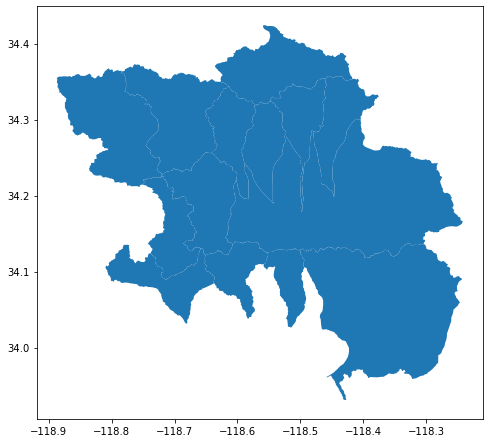

In [4]:
huc12.plot(figsize=(8, 8));

Next, let's get wetlands using the [National Wetlands Inventory](https://www.fws.gov/wetlands/) WMS service. First we need to connect to the service using ``WMS`` class.

In [5]:
wms = WMS(
    ServiceURL().wms.fws,
    layers="0",
    outformat="image/tiff",
    crs="epsg:3857",
)

In [6]:
wms

Connected to the WMS service with the following properties:
URL: https://www.fws.gov/wetlands/arcgis/services/Wetlands_Raster/ImageServer/WMSServer
Version: 1.3.0
Layers: 0
Output Format: image/tiff
Output CRS: epsg:3857

Then we can get the data using the ``getmap_bybox`` function. Note that this function only accpets a bounding box, so we need to pass a bounding box and mask the returned data later on usin ``pygeoutils.gtiff2xarray`` function.

In [7]:
r_dict = wms.getmap_bybox(
    basin_geom.geometry[0].bounds,
    1e3,
    box_crs="epsg:4326",
)
wetlands = geoutils.gtiff2xarray(r_dict, basin_geom.geometry[0], "epsg:4326")

There are three bands in the returned data. Using the information provided for the layer [here](https://www.fws.gov/wetlands/arcgis/rest/services/Wetlands/MapServer/0) we can find the color code of emergent wetlands and extract them.

In [8]:
emergent = np.array([127, 195, 28])
wl_emergent = wetlands.where((wetlands.isel(band=0) == emergent[0])
                        & (wetlands.isel(band=1) == emergent[1])
                        & (wetlands.isel(band=2) == emergent[2]))

For plotting the wetlands note that in our request we set the CRS to EPSG:3857 so we need transform the watershed geometry to this CRS so they can be superimposed.

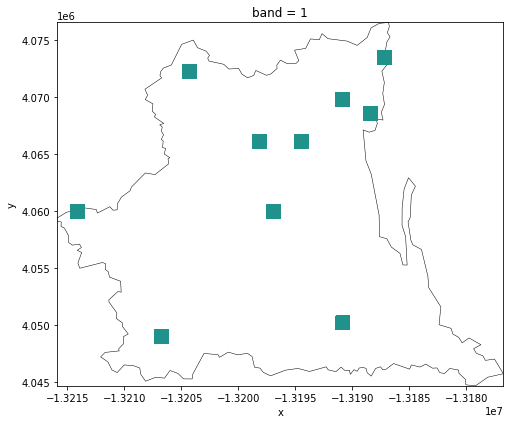

In [9]:
basin_3857 = basin_geom.to_crs("epsg:3857")
ax = basin_3857.plot(facecolor="none", edgecolor="k", lw=0.5, figsize=(8, 8))
wl_emergent.isel(band=0).plot(ax=ax, add_colorbar=False);

Next, let's getthe base flood elevation data from [FEMA](https://hazards.fema.gov/gis/nfhl/rest/services/public/NFHL/MapServer/16) and use ``pygeoutils.json2geodf`` to convert it into a GeoDataFrame.

In [10]:
wfs = WFS(
    ServiceURL().wfs.fema,
    layer="public_NFHL:Base_Flood_Elevations",
    outformat="esrigeojson",
    crs="epsg:4269",
)

In [11]:
wfs

Connected to the WFS service with the following properties:
URL: https://hazards.fema.gov/gis/nfhl/services/public/NFHL/MapServer/WFSServer
Version: 2.0.0
Layer: public_NFHL:Base_Flood_Elevations
Output Format: esrigeojson
Output CRS: epsg:4269

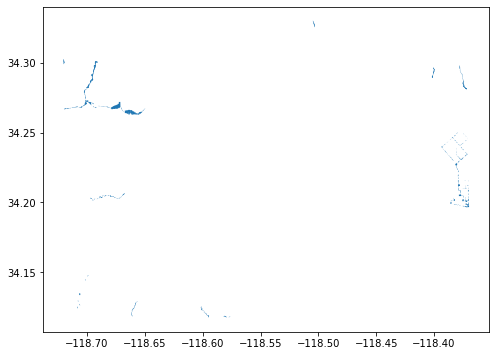

In [12]:
r = wfs.getfeature_bybox(basin_geom.geometry[0].bounds, box_crs="epsg:4326")
flood = geoutils.json2geodf(r.json(), "epsg:4269", "epsg:4326")
flood.plot(figsize=(8, 8));

Moreover, we can use `getfeature_byfilter` class method for using a [CQL](https://docs.geoserver.org/stable/en/user/tutorials/cql/cql_tutorial.html) filter:

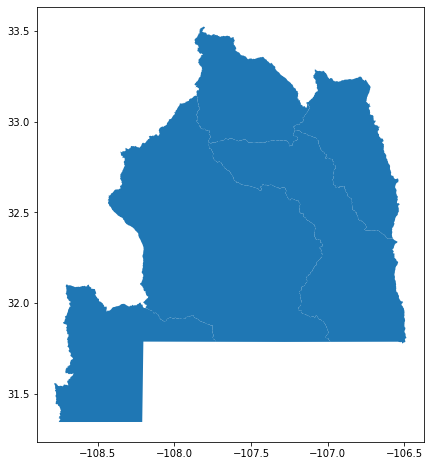

In [15]:
layer = "wmadata:huc08"
wfs = WFS(
    ServiceURL().wfs.waterdata,
    layer=layer,
    outformat="application/json",
    version="2.0.0",
    crs="epsg:900913",
)
r = wfs.getfeature_byfilter(f"huc8 LIKE '13030%'")
huc8 = geoutils.json2geodf(r.json(), "epsg:900913", "epsg:4326")
huc8.plot(figsize=(8, 8));